# House Price Prediction Project  

**Goal:** Predict house prices using an XGBoost pipeline  

**Author:** [Nimota Ibrahim](https://github.com/NimotaPro/NimotaPro)  

**Table of Contents**
1. Introduction 
2. Dataset
3. Features with High Missing Values
4. Train-Validation Split
5.  Data Cleaning and Feature Engineering
6.  Selecting Categorical & Numeric Columns
7.  Selecting Categorical Columns
8.  Selecting Numeric Columns
9.  Define the Modeling Feature Blueprint
10. Import the Test Dataset
11. Unified Data Cleg & Feature Engineering Function
12. Model & Pipeline
13. Model Performance: Mean Absolute Error
14. Feature Importance & Visualization
15. Residual Analysis & Visualisation
16. Residual Diagnostics
17. First Attempt to Improve the Model: Outlier Removal
18. Second Attempt at Model Improvement: Feature Engineering
19. Implementation of Decision Support Logic
20. Business Impact & Future Roadmap
21. Project Summary






# 1. Introduction

This project implements an **end-to-end residential price prediction system** designed using production-oriented machine learning principles, rather than focusing solely on isolated model training. The system emphasizes **predictive accuracy, robustness across data splits, transparent error analysis, and interpretability**, ensuring reliable performance even under imperfect data conditions.

An **XGBoost-based decision pipeline** was constructed, in which all preprocessing steps, including feature selection, imputation, and transformation, were fitted exclusively on the training data. This prevents **data leakage** and reflects real-world deployment conditions, where future data must be processed without access to target values.

**Model performance was evaluated primarily using Mean Absolute Error (MAE)** due to its direct interpretability in monetary terms and relevance to property valuation tasks. **k-fold cross-validation** was used as a supplementary diagnostic tool to assess stability and sensitivity to data partitioning.

Beyond prediction, the system integrates a **decision-support layer** that automatically flags properties with significant pricing anomalies. This functionality **reduces manual workload**, allowing analysts to focus only on the listings requiring attention. 


### 1.1 Libraries & Tools

* **Data Manipulation:** pandas, numpy
* **Machine Learning:** scikit-learn, XGBoost
* **Visualization:** matplotlib, seaborn, plotly
* **Interpretability:** shap

# 2. Datasets


The datasets used in this project (train.csv and test.csv), part of the Ames Housing dataset, were obtained from **Kaggle** and consist of residential property sales records. Each row represents a single property, with columns capturing structural attributes and sale prices. A full description of all variables is provided in the accompanying data description file (data_description.txt), originally prepared by Dean De Cock and lightly edited to match the column names used in this project. The full datasets and accompanying documentation are publicly available via the Kaggle repository link **[here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)**.


The datasets contain a rich mix of numerical, nominal, and ordinal categorical variables, making them well-suited for supervised regression modeling with tree-based methods such as XGBoost.

**Note on source**: The original dataset comes from the Kaggle competition "House Prices: Advanced Regression Techniques." Accessing it directly from Kaggle requires joining the competition. 

To ensure reproducibility without requiring Kaggle account access, the training and test CSV files (**renamed ml_housing_train.csv and ml_housing_test.csv**) as well as the accompanying data description text file are included directly in this GitHub repository alongside the notebook.


In [399]:
# Load and preview data

import pandas as pd


df = pd.read_csv('ml_housing_train.csv', index_col='Id')
df.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 2.1 Dataset Inspection

In [402]:
# Inspect the structure of the dataset using .info()
# Total rows: 1,460; total columns: 80
# Column types: 43 object/text, 34 integer, 3 float
# Some columns contain missing values (e.g., 'Alley' has only 91 non-null entries out of 1,460)

# Missing values will be handled during preprocessing:
# - Columns with a high percentage of missing values may be dropped
# - Other missing values will be imputed using assigned placeholders 



df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

### 2.2 Feature-Target Separation

In [405]:
# Define the target variable (SalePrice) 

y = df.SalePrice


In [407]:
# Select feature columns/ drop the target column 


df.drop(['SalePrice'], axis=1, inplace=True)


In [409]:
# Confirm that the target column has been dropped (79 columns remain)


df.shape


(1460, 79)

# 3. Features with High Missing Values

* Feature columns with at **least 90% missing values** are  are **excluded** to reduce noise and improve model reliability

* The 3 columns are **PoolQC, MiscFeature, and Alley**  

 


In [412]:
# Identify feature columns with more than >=90% missing values
# First, compute the percentage of missing values for each column


missing_percent = df.isnull().mean() * 100
print('Columns with high missing values:\n')
print(missing_percent.sort_values(ascending=False))


Columns with high missing values:

PoolQC           99.520548
MiscFeature      96.301370
Alley            93.767123
Fence            80.753425
MasVnrType       59.726027
                   ...    
Heating           0.000000
MSZoning          0.000000
CentralAir        0.000000
1stFlrSF          0.000000
SaleCondition     0.000000
Length: 79, dtype: float64


In [414]:
# Display columns with high missing values (>=90%) 
# Total columns with high missing values: 3 (e.g., PoolQC has >99% missing)
# These extremely sparse columns will be dropped 




high_missing = pd.DataFrame(
    [(feature, percent_value) for feature, percent_value in missing_percent.items() if percent_value >= 90],
    columns=['SparseFeature', 'MissingPercent']
)

print(high_missing)
print('\nTotal number of columns with high missing values:', len(high_missing))


  SparseFeature  MissingPercent
0         Alley       93.767123
1        PoolQC       99.520548
2   MiscFeature       96.301370

Total number of columns with high missing values: 3


In [416]:
# Drop columns with high missing values (Alley, PoolQC, MiscFeature) 


cols_to_drop = ['Alley', 'PoolQC', 'MiscFeature']
X = df.drop(columns = cols_to_drop)



In [418]:
# Verify dataset structure after dropping high-missing features (76 features)


X.shape


(1460, 76)

# 4. Train-Validation Split


* Following the train-validation split, all **data cleaning and manipulation procedures** are applied **exclusively to the training set**

* The resulting transformations are formalised into a single **reusable function** and applied identically to the **validation and test sets**

In [421]:

# We split the data 80/20 to ensure we have a robust validation set for testing the model's generalization on unseen data

# X_train_full: input features for model training
# X_valid_full: input features for validation
# y_train: target values for model training
# y_valid: target values for validation (these are the values the model will try to predict)

from sklearn.model_selection import train_test_split

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)


# 5. Data Cleaning and Feature Engineering 

The preprocessing steps on the train set include: 
* (i) conversion of MSSubClass and MoSold to string type to ensure they are treated as categorical features
* (ii) conversion of structural missing values to 0 for numerical features and 'None' for categorical features
* (iii) replacement of Neighborhood and Exterior2nd with engineered features (Neighborhood_enc and Has2ndExterior)



#### Newly Created Columns

* **Neighborhood Encoded (Neighborhood_enc)**: Replaces each neighborhood with the **average SalePrice** in the corresponding area, converting a          categorical variable into a numeric feature that reflects local market value
* **Has Second Exterior (Has2ndExterior)**: Binary feature indicating whether the home has different materials on the front and back exteriors



### 5.1 MSSubClass and MoSold Conversion

* These two columns are nominal categorical variables, not numeric measurements.
* Example: MoSold (month sold) **12 (Dec)** is not "larger" than **1 (Jan)**, and MSSubClass codes (e.g., 20, 60) do not imply numeric order.
* Treating them as numeric could mislead the model.
* The columns are **converted to string** type so they are correctly handled as categorical features.


In [425]:
# Convert MSSubClass and MoSold to string (object) type to ensure they are treated as categorical features


X_train_full[['MSSubClass', 'MoSold']] = X_train_full[['MSSubClass', 'MoSold']].astype(str)

### 5.2 Handling Structural (False) Missing Values

* There are a total of **16 columns** in the train dataset that contain missing values.

* Out of these, several contain **“fake” missing data**, originally recorded as NA (Not Available). Treating these as standard missing values could introduce **false information** into the model.

* For these columns, NaN will be **replaced with 'None' for categorical features** and with **0 for numeric features** in the training data (X_train_full). This ensures the model captures the **absence of a feature** rather than missing information.

### 5.3 Electrical and LotFrontage (Truly Missing Data)

* Two columns, **Electrical** and **LotFrontage**, are left as NaN because they represent **true missing information**- data that should exist but was    not recorded.

* **Electrical:** Retained as NaN and subsequently **encoded as 0 during ordinal encoding**, corresponding to the lowest quality level.

* **LotFrontage**: Also retained as NaN and **imputed within the modelling pipeline** using SimpleImputer(strategy='median'), as skewness analysis        classified it as a highly skewed numeric feature, for which median imputation is more robust to outliers and extreme values.


In [428]:
# Display the remaining columns with missing values (16 total), after high-missingness features (>=90%) were dropped


print(X_train_full.isnull().sum()[X_train_full.isnull().sum() > 0])

print("\nNumber of columns with at least one missing value:", len(X_train_full.isnull().sum()[X_train_full.isnull().sum() > 0]))


LotFrontage     212
MasVnrType      707
MasVnrArea        6
BsmtQual         28
BsmtCond         28
BsmtExposure     28
BsmtFinType1     28
BsmtFinType2     29
Electrical        1
FireplaceQu     551
GarageType       58
GarageYrBlt      58
GarageFinish     58
GarageQual       58
GarageCond       58
Fence           954
dtype: int64

Number of columns with at least one missing value: 16


### 5.4 Handling Structural and True Missing Values

In [431]:
# Handling missing values:
# - Structural missingness: feature absent, fill 'None' (categorical) or 0 (numeric)
# - True missing values: genuinely unknown, keep as NaN for later imputation


# 1. Group by the replacement value

none_cols = [
    'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
    'GarageQual', 'GarageCond', 'Fence'
]
zero_cols = ['MasVnrArea', 'GarageYrBlt']


# 2. Apply the fixes to X_train_full (on both sets)

X_train_full[none_cols] = X_train_full[none_cols].fillna('None')
X_train_full[zero_cols] = X_train_full[zero_cols].fillna(0)

# 6. Selecting Categorical and Numeric Columns

### Overview

The dataset is divided into **categorical** and **numeric** features. Categorical variables are further grouped into **ordinal** (ordered) and **nominal** (one-hot encoded) categories.



### Ordinal Encoding

* Ordinal encoding converts ordered categorical levels into numeric values that preserve their natural hierarchy.
* Ordinal features (**ordinal_cols**) are manually mapped to integers during early preprocessing and passed unchanged into the final pipeline.



### One-Hot Encoding

* One-hot encoding represents each category as a binary indicator, preventing the model from assuming ordinal relationships.
* Nominal categorical features with low cardinality (**ohe_cols**) are encoded using One-Hot Encoding.



### Handling Missing Values

* **SimpleImputer** is used to ensure no unresolved missing values remain before modeling.
* Numeric features are imputed using mean or median values, as determined during preprocessing, to maintain data consistency while minimizing bias.



### High-Cardinality Feature: *Neighborhood*

* Cardinality refers to the number of unique categories in a feature.
* One-hot encoding high-cardinality features can increase dimensionality and model complexity.
* The **Neighborhood** feature (**25 unique values**) is **target encoded using mean SalePrice** and treated as **numeric** to improve model efficiency.



### Preprocessing Pipeline

**Numeric columns**:

##### Skewness was assessed during exploratory analysis

While XGBoost is theoretically invariant to the distribution of features, the values used for imputation are not. Using a Mean to fill missing values in a heavily skewed feature (like Lot Frontage) would inject 'ghost outliers' into the dataset. My strategy uses skewness as a diagnostic tool: **by selecting the Median for skewed features, I ensure that imputed values are representative of the typical observation**, thereby maintaining the structural integrity of the feature space regardless of the model used.


* **Columns with low to moderate skew**: where the mean reflects typical values, are imputed using the **mean**

* **Highly skewed columns**: are imputed using the **median** to reduce the impact of extreme values



**Categorical columns**:

* **Moderate-to-low cardinality features** are encoded using One-Hot Encoding.

* **Ordinal features** are manually encoded during early preprocessing and passed through unchanged. This **ensures consistent, reproducible mappings** and keeps knowledge-driven definitions separate from data-driven pipeline operations.

# 7. Selecting Categorical Columns

### 7.1 High Cardinality Features

* Identify categorical columns with many unique values, which may require special encoding or handling
  
* Only Neighborhood has high cardinality

In [435]:
# Identify high-cardinality categorical columns (20 or more unique values)



high_cardinality = [
    col_name for col_name in X_train_full.columns 
    if X_train_full[col_name].nunique() >= 20 
       and X_train_full[col_name].dtype == 'object'
]

# Display the high-cardinality column(s) 
print("High-cardinality column(s):", high_cardinality)


# Count of high-cardinality 
print("\nTotal number of high-cardinality:", len(high_cardinality))



# Display unique value counts for high-cardinality column(s)
value_counts = [(col, X_train_full[col].nunique()) for col in high_cardinality]

print(f"\nNumber of Unique Values: {value_counts}")


High-cardinality column(s): ['Neighborhood']

Total number of high-cardinality: 1

Number of Unique Values: [('Neighborhood', 25)]


### 7.2 Target-Encode the Neighborhood Column 
* Replace with **Neighborhood_enc**

This encoding approach complements XGBoost’s tree-based structure, which is robust to feature scaling and skewed distributions. By using the actual average prices for each neighborhood, the **model accurately identifies expensive and cheaper areas without artificially lowering or inflating values** through smoothing

In [438]:
# Neighborhood is target-encoded using only the training labels (y_train) to avoid data leakage
# Then replaced in the feature set with the numeric Neighborhood_enc column


# Compute mean SalePrice per Neighborhood
neighborhood_means = y_train.groupby(X_train_full['Neighborhood']).mean()

# Map means to the training set
X_train_full['Neighborhood_enc'] = X_train_full['Neighborhood'].map(neighborhood_means).round(2)


# Drop original Neighborhood column
X_train_full.drop(columns=['Neighborhood'], inplace=True)

# Preview the newly created feature
print(X_train_full['Neighborhood_enc'].head())




Id
619    315236.57
871    145902.22
93     216634.68
818    157510.38
303    202313.02
Name: Neighborhood_enc, dtype: float64


### 7.3 Exterior1st and Exterior2nd
* Fix discrepancies found between these 2 columns
* Create a replacement for Exterior2nd
* Drop Exterior2nd

In [441]:
# print the unique values in both Exterior1st and Exterior2nd as a DataFrame for easy "eyeballing"
# identify and fix the spelling errors found, using the data decsription file provided
# this will ensure identical materials are treated as a single statistical group


df_exterior = pd.DataFrame([sorted(X_train_full['Exterior1st'].unique()), sorted(X_train_full['Exterior2nd'].unique())])
df_exterior

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,AsbShng,AsphShn,BrkComm,BrkFace,CBlock,CemntBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing,None
1,AsbShng,AsphShn,Brk Cmn,BrkFace,CBlock,CmentBd,HdBoard,ImStucc,MetalSd,Other,Plywood,Stone,Stucco,VinylSd,Wd Sdng,Wd Shng


In [443]:
# Identify the symmetric difference (items in one but not both)

diff = set(X_train_full['Exterior1st']) ^ set(X_train_full['Exterior2nd'])
print(f"Variables to fix: {sorted(diff)}")

Variables to fix: ['Brk Cmn', 'BrkComm', 'CemntBd', 'CmentBd', 'Other', 'Wd Shng', 'WdShing']


In [445]:
# Standardize inconsistent abbreviations across both columns to ensure uniform categories

mapping = {
    'Brk Cmn': 'BrkComm', 
    'CmentBd': 'CemntBd', 
    'Wd Shng': 'WdShing'  
}

X_train_full['Exterior1st'] = X_train_full['Exterior1st'].replace(mapping)
X_train_full['Exterior2nd'] = X_train_full['Exterior2nd'].replace(mapping)


#  Create binary feature: Has2ndExterior
# Compare specific materials before grouping them into 'Other' to prevent masking true differences

X_train_full['Has2ndExterior'] = (X_train_full['Exterior1st'] != X_train_full['Exterior2nd']).astype(int)



# Safely group rare categories (< 12 occurrences) into 'Other' to reduce cardinality and prevent overfitting

counts = X_train_full['Exterior1st'].value_counts()
rare_ext = counts[counts < 12].index
X_train_full['Exterior1st'] = X_train_full['Exterior1st'].replace(rare_ext, 'Other')


# Drop Exterior2nd as its primary predictive value is now captured in 'Has2ndExterior'

X_train_full.drop('Exterior2nd', axis=1, inplace=True)


In [447]:
# Visually confirm the transformation:
# - Neighborhood and Exterior2nd are no longer present
# - Neighborhood_enc and Has2ndExterior are visible in the last two columns



X_train_full.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Neighborhood_enc,Has2ndExterior
Id,,,,,,,,,,,,,,,,,,,,,
619,20,RL,90.0,11694,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,260,0,None,0,7,2007,New,Partial,315236.57,0
871,20,RL,60.0,6600,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,None,0,8,2009,WD,Normal,145902.22,0
93,30,RL,80.0,13360,Pave,IR1,HLS,AllPub,Inside,Gtl,...,0,0,None,0,8,2009,WD,Normal,216634.68,0
818,20,RL,NaN,13265,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,None,0,7,2008,WD,Normal,157510.38,0
303,20,RL,118.0,13704,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,None,0,1,2006,WD,Normal,202313.02,0


### 7.4 Define Categorical Columns

In [450]:
# Get all categorical columns
# These will be further divided into ordinal_cols and ohe_cols for ordinal and one hot encoding respectively


categorical_cols = [col_name for col_name in X_train_full.columns if X_train_full[col_name].dtype == 'object']



# Display the total number and list of ctegorical columns

print('Number of categorical columns:', len(categorical_cols))
print('\n', categorical_cols)



Number of categorical columns: 40

 ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MoSold', 'SaleType', 'SaleCondition']


### 7.5 Splitting Categorical Features into Ordinal and One-Hot
#### Identification based on predefined Value Fingerprints


In [453]:
import numpy as np

# NumPy is imported to handle np.nan (true missing values) in ordinal category fingerprints

# 1. Define the possible "fingerprints" for ordinal columns

# The 6-point Quality Scale (Used by 9 columns)
quality_fp = {'None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'}


# The Basement Finish Scale (types 1 & 2)
bsmt_finish_fp = {'None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'}



# Other unique individual fingerprints

bsmt_exposure_fp = {'None', 'No', 'Mn', 'Av', 'Gd'}
shape_fp = {'IR3', 'IR2', 'IR1', 'Reg'}
contour_fp = {'Low', 'HLS', 'Bnk', 'Lvl'}
utility_fp = {'ELO', 'NoSeWa', 'NoSewr', 'AllPub'}
slope_fp = {'Sev', 'Mod', 'Gtl'}
functional_fp = {'Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'}
paved_fp = {'N', 'P', 'Y'}
fence_fp = {'None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'}
central_air_fp = {'N', 'Y'}
electrical_fp = {np.nan, 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'}
garage_finish_fp = {'None', 'Unf', 'RFn', 'Fin'}
garage_type_fp = {'None', 'Detchd', 'CarPort', 'BuiltIn', 'Basment', 'Attchd', '2Types'}



# 2. Combine them into one master "Ordinal Identity" set

all_ordinal_fingerprints = quality_fp | bsmt_exposure_fp | bsmt_finish_fp | shape_fp | contour_fp | utility_fp |  slope_fp | functional_fp\
| paved_fp | fence_fp | central_air_fp | electrical_fp | garage_finish_fp | garage_type_fp




# 3. Fetch columns where the unique values are a SUBSET of fingerprints

ordinal_cols = [col for col in X_train_full.select_dtypes(include='object').columns
                if set(X_train_full[col].unique()).issubset(all_ordinal_fingerprints)]

# Display ordinal categorical columns
print('Ordinal Columns:\n', ordinal_cols)


# 4. Everything else in categorical columns is One-Hot
ohe_cols = [col for col in X_train_full.select_dtypes(include='object').columns 
            if col not in ordinal_cols]

# Display categorical one-hot columns
print('\nOne Hot Columns:\n', ohe_cols)

# Confirm that ordinal and one hot columns add up to 40 (full categorical column count)
print('\nOrdinal + One-Hot columns should add up to total categorical columns (40):')
print(f'Number of Ordinal Columns -> {len(ordinal_cols)} | Number of One Hot Columns -> {len(ohe_cols)} | Total: {len(ordinal_cols) + len(ohe_cols)}')


Ordinal Columns:
 ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence']

One Hot Columns:
 ['MSSubClass', 'MSZoning', 'Street', 'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'Foundation', 'Heating', 'MoSold', 'SaleType', 'SaleCondition']

Ordinal + One-Hot columns should add up to total categorical columns (40):
Number of Ordinal Columns -> 23 | Number of One Hot Columns -> 17 | Total: 40


### 7.6 Ordinal Encoding of Ordered Categorical Features


The decision to handle Ordinal Encoding manually, outside the Scikit-Learn pipeline, is a deliberate architectural choice favoring **auditability**. By **separating Knowledge-Driven definitions** (how we define quality) from **Data-Driven transformations** (how the model scales numbers), the logic remains transparent to stakeholders. This prevents 'logic-drift' where a model might internally re-map categories in a way that no longer aligns with real-world domain expertise

In [456]:

# 1. Define the Group Ranking Lists (Worst to Best)
qual_rank = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']                    # used by 9 columns
bsmt_fin_rank = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']    # used by 2 columns

# 2. Map Column Names to their specific Ranks
ordinal_mapping_dict = {
    # 6-point Quality Rank
    'ExterQual': qual_rank, 'ExterCond': qual_rank, 'BsmtQual': qual_rank, 
    'BsmtCond': qual_rank, 'HeatingQC': qual_rank, 'KitchenQual': qual_rank, 
    'FireplaceQu': qual_rank, 'GarageQual': qual_rank, 'GarageCond': qual_rank,
    
    # Basement Finish Rank
    'BsmtFinType1': bsmt_fin_rank,
    'BsmtFinType2': bsmt_fin_rank,

    # Unique Ranks
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],    
    'Functional':   ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageType':   ['None', 'Detchd', 'CarPort', 'BuiltIn', 'Basment', 'Attchd', '2Types'],
    'Electrical':   [np.nan, 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],    
    'LotShape':     ['IR3', 'IR2', 'IR1', 'Reg'],
    'LandContour':  ['Low', 'HLS', 'Bnk', 'Lvl'],
    'Utilities':    ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope':    ['Sev', 'Mod', 'Gtl'],
    'PavedDrive':   ['N', 'P', 'Y'],
    'Fence':        ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    'CentralAir':   ['N', 'Y']
}


# 3. Encode ordinal columns
# For each column with a predefined ranking, replace categorical values with corresponding ordinal scores
# Higher numbers indicate better quality

for col, rank_list in ordinal_mapping_dict.items():
    if col in X_train_full.columns:
        # Create mapping from category to ordinal index
        mapping_dict = {val: i for i, val in enumerate(rank_list)}
        
        # Apply mapping to the column
        X_train_full[col] = X_train_full[col].map(mapping_dict)


In [458]:

# Preview the transformed ordinal features to confirm all 23 ordinal columns have been successfully encoded as numeric values


X_train_full[ordinal_cols].head()

,LotShape,LandContour,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,...,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence
Id,,,,,,,,,,,,,,,,,,,,,
619,3,3,3,2,5,3,5,3,3,6,...,5,4,0,4,5,1,3,3,2,0
871,3,3,3,2,3,3,3,3,1,1,...,5,3,0,0,1,1,3,3,2,0
93,2,1,3,2,3,4,4,3,1,5,...,5,3,0,0,1,1,3,3,2,0
818,2,3,3,2,4,3,4,3,1,6,...,5,4,0,4,5,2,3,3,2,0
303,2,3,3,2,4,3,4,3,1,1,...,5,4,0,3,5,2,3,3,2,0


# 8. Selecting Numeric Columns

* Select numeric features
* Perform skewness test to decide mean vs. median imputation


In [461]:
# Select numeric columns from the training dataset 

numeric_cols = [col_name for col_name in X_train_full.columns if X_train_full[col_name].dtype in ['int64', 'int32', 'float64', 'float32']
                and col_name not in ordinal_cols]



# Display the total number and list of numeric columns

print('Number of numeric columns:', len(numeric_cols))
print()
print(numeric_cols)


Number of numeric columns: 36

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'Neighborhood_enc', 'Has2ndExterior']


### 8.1 Numeric Feature Analysis & Imputation Strategy Selection

**Skewness guides the choice** of mean or median imputation **to ensure missing values reflect typical observations**, preserving feature integrity even for models like XGBoost that are insensitive to distribution


In [464]:
# Inspect distribution properties of each numeric feature
for col in numeric_cols:
    mean_val = round(X_train_full[col].mean(), 2)
    median_val = round(X_train_full[col].median(), 2)
    skew = X_train_full[col].skew() 


# Split numeric columns based on skewness magnitude
# Right Skew/ Highly skewed features: median imputation (robust to outliers)
median_numeric_cols = [
    col for col in numeric_cols
    if abs(X_train_full[col].skew()) > 1
]

# Left Skew / low to moderately skewed features: mean imputation (efficient for symmetric data)
mean_numeric_cols = [
    col for col in numeric_cols
    if abs(X_train_full[col].skew()) <= 1
]

print("Median-impute numeric columns:\n", median_numeric_cols)
print("\nMean-impute numeric columns:\n", mean_numeric_cols)

# Check: total numeric columns
print('\nConfirm that mean and median numeric columns add up to total numeric columns (36):')
print(f'Mean Columns: {len(mean_numeric_cols)} | Median Columns: {len(median_numeric_cols)} | Total: {len(mean_numeric_cols) + len(median_numeric_cols)}')


Median-impute numeric columns:
 ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF2', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'Neighborhood_enc', 'Has2ndExterior']

Mean-impute numeric columns:
 ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'YrSold']

Confirm that mean and median numeric columns add up to total numeric columns (36):
Mean Columns: 18 | Median Columns: 18 | Total: 36


### 9. Define the Modeling Feature Blueprint 

* Create final train feature dataframe: X_train


In [467]:
# X_train: feature matrix of selected predictors


my_cols = ordinal_cols + ohe_cols + median_numeric_cols + mean_numeric_cols

X_train = X_train_full[my_cols].copy()

### 10. Import the Test Dataset

#### **Test dataset loaded for completeness (predictions not included in this project)**

The test dataset is included to demonstrate consistent preprocessing across datasets.  
Predictions on the test set are not included, as the **focus of this project is on feature engineering, data cleaning, and pipeline design**.  
Model evaluation and performance assessment have been carried out on a dedicated **validation set**, providing a reliable measure of predictive accuracy without exposing the final unseen test data.




* Create a unified function, **adapting the exact steps used in train set** cleaning
* Apply the function on the **validation and test** sets
* This is to ensure all datasets share the **same structure and transformations**
  

In [470]:
# X_test_full: full test feature dataset

X_test_full = pd.read_csv('ml_housing_test.csv', index_col='Id')
X_test_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [472]:
# Confirm test dataset dimensions


X_test_full.shape

(1459, 79)

# 11. Unified Data Cleaning & Feature Engineering Function

* Applies the cleaning and feature engineering steps to validation and test sets (X_valid_full and X_test_full)

In [475]:
# Column Blueprint (my_cols): the exact set of features to keep for modeling
# Any column not listed here (e.g. Alley, PoolQC, Neighborhood, Exterior2nd) is implicitly dropped
# Steps taken on X_test_full, to be re-applied to X_valid_full and X_test_full

my_cols = ordinal_cols + ohe_cols + median_numeric_cols + mean_numeric_cols


def clean_dataset(df):
    df = df.copy()

    # Step 1: Ensure data types match
    # Convert to string and remove possible leading zeros: "01" -> "1", "09" -> "9"
    df['MoSold'] = df['MoSold'].astype(str).str.lstrip('0')
    df['MSSubClass'] = df['MSSubClass'].astype(str)


    # Step 2: Structural NaNs     
    df[none_cols] = df[none_cols].fillna('None')
    df[zero_cols] = df[zero_cols].fillna(0)
    
   # Step 3: Neighborhood 
    df['Neighborhood_enc'] = df['Neighborhood'].map(neighborhood_means).round(2)
    df['Neighborhood_enc'] = df['Neighborhood_enc'].fillna(y_train.mean()).round(2)

    # Step 4: Exterior
    df['Exterior1st'] = df['Exterior1st'].replace(mapping)
    df['Exterior2nd'] = df['Exterior2nd'].replace(mapping)
    
    # Create Binary feature, then group rare items into 'Other'
    df['Has2ndExterior'] = (df['Exterior1st'] != df['Exterior2nd']).astype(int)

    # Group rare items
    df['Exterior1st'] = df['Exterior1st'].replace(rare_ext, 'Other')
    
    # Safety net for unseen test Exterior1st categories
    valid_names = X_train_full['Exterior1st'].unique() 
    df.loc[~df['Exterior1st'].isin(valid_names), 'Exterior1st'] = 'Other'


    # Step 5: Ordinal Encoding
    # This converts strings to numbers for Ordinal Columns
    for col in ordinal_cols:
        if col in df.columns and col in ordinal_mapping_dict:
            # Get the specific rank list for this column
            rank_list = ordinal_mapping_dict[col]
            
            # Create {category: index} mapping
            mapping_dict = {val: i for i, val in enumerate(rank_list)}
            
            # fillna(0) handles unseen categories or future NaNs by assigning a deterministic lowest-rank value
            df[col] = df[col].map(mapping_dict).fillna(0).astype(int)        
          
    
    return df[my_cols]

    

### 11.1 Validation and Test Data Cleaning (Using the Predefined Function)

In [478]:
# 1. Clean the test data
X_valid = clean_dataset(X_valid_full)

# 2. Clean the test data
X_test = clean_dataset(X_test_full)

### 11.2 Feature Consistency Check Across Data Splits

* LotFrontage was intentionally retained as missing and handled via Pipeline imputation for the training and validation sets
* Additional missing values appear in X_test that were not observed during model training, reflecting real-world inference conditions
* These are handled automatically and consistently by the Pipeline's imputation step


In [481]:
# Sanity check: verify that train, validation, and test sets have the same number of feature columns

print("Train Data Shape:", X_train.shape)
print("Validation Data Shape:", X_valid.shape)
print("Test Data Shape: ", X_test.shape)

print()

# Verify remaining missing values across the training, validation, and test sets

print("Columns with NaNs in X_train:", X_train.columns[X_train.isna().any()].tolist())
print("Columns with NaNs in X_valid:", X_valid.columns[X_valid.isna().any()].tolist())
print("Columns with NaNs in X_test:", X_test.columns[X_test.isna().any()].tolist())

    


Train Data Shape: (1168, 76)
Validation Data Shape: (292, 76)
Test Data Shape:  (1459, 76)

Columns with NaNs in X_train: ['LotFrontage']
Columns with NaNs in X_valid: ['LotFrontage']
Columns with NaNs in X_test: ['MSZoning', 'SaleType', 'LotFrontage', 'BsmtFinSF2', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'GarageCars', 'GarageArea']


# 12. Model & Pipeline

**XGBoost** (Extreme Gradient Boosting) is selected as the model. It is a gradient-boosted decision tree algorithm that builds trees sequentially, with each tree correcting the errors of its predecessors, making it well suited for capturing complex, non-linear relationships in structured data.  

The pipeline was implemented using scikit-learn’s Pipeline and ColumnTransformer for preprocessing, with SimpleImputer and OneHotEncoder for feature handling.

### 12.1 Parameter Explanation

**n_estimators = 1000**

* The number of boosting trees. A higher number allows the model to learn patterns gradually while working with a low learning rate to reduce overfitting and maintain stability.

**learning_rate = 0.05**

* Scales the contribution of each tree. A relatively small value promotes smoother convergence and improves generalisation.

**max_depth = 6**

* Limits tree complexity to prevent overfitting and balance model expressiveness with generalisation.

**n_jobs = -1**

* Utilises all available CPU cores, improving computational efficiency without affecting model behaviour.

**random_state = 42**

* Ensures reproducibility of results, enabling consistent evaluation.


In [484]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

# 1. Define transformers for numeric and categorical features (ordinal columns handled separately)
# Imputers ensure future missing values are handled


# Mean-impute numeric columns
mean_transformer = SimpleImputer(strategy='mean')

# Median-impute numeric columns (including LotFrontage)
median_transformer = SimpleImputer(strategy='median')

# One-hot encode categorical columns with missing value imputation
ohe_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 2. ColumnTransformer: apply numeric/categorical preprocessing, pass through manually encoded ordinals

preprocessor = ColumnTransformer(
    transformers=[
        ('num_mean', mean_transformer, mean_numeric_cols),
        ('num_med', median_transformer, median_numeric_cols),
        ('cat_ohe', ohe_transformer, ohe_cols),
        ('ord_pass', 'passthrough', ordinal_cols)
    ])

# 3. The Adaptable XGBoost Pipeline
my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators = 1000, 
        learning_rate = 0.05, 
        max_depth = 6, 
        n_jobs = -1, 
        random_state=42
    ))
])


In [486]:
# Fit, using the cleaned training data
my_pipeline.fit(X_train, y_train)

# Predict on validation set
predictions = my_pipeline.predict(X_valid)


# 13. Model Performance: Mean Absolute Error

In [489]:
# Evaluate model performance on the validation set using Mean Absolute Error (MAE)

from sklearn.metrics import mean_absolute_error

predictions = my_pipeline.predict(X_valid)
print(f"Mean Absolute Error: {mean_absolute_error(predictions, y_valid):.2f}")

Mean Absolute Error: 15445.43


### 13.1 Mean Absolute Percentage Error

In [492]:
# Calculate Mean Absolute Percentage Error (MAPE)

mape = np.mean(np.abs((y_valid - predictions) / y_valid)) * 100
print(f"Typical Error: {mape:.2f}%")

Typical Error: 8.75%


### 13.2 Five-fold Cross-Validation

Although XGBoost has its own cross-validation, I **used scikit-learn’s cross_val_score to evaluate the full pipeline**.  

This ensures that preprocessing steps are included and that MAE metrics are consistent and reproducible across folds


In [495]:
from sklearn.model_selection import cross_val_score

# 1. Clean the entire dataset with unified function
X_cleaned = clean_dataset(X) 

scores = -1 * cross_val_score(my_pipeline, X_cleaned, y, cv=5, scoring='neg_mean_absolute_error')

print(f"Average MAE across 5 folds: {scores.mean():.2f}")
print(f"Stability (Standard Deviation): {scores.std():.2f}")

Average MAE across 5 folds: 15612.92
Stability (Standard Deviation): 1306.57


### 13.3 Model Stability: Holdout vs Cross-Validation

While **XGBoost** gradually reduces errors during training, the **model’s measured performance on one holdout set can fluctuate** if that set happens to contain unusually high or low priced houses.

**5-fold cross-validation** provides a **more robust estimate** of model performance across the dataset.  

The holdout MAE (`$15,445`) is closely aligned with the CV mean (`$15,613`), and the CV standard deviation (`$1,307`) indicates that the model is **stable and not overfitting**.  


In [498]:
# Comparison of holdout and cross-validation errors to assess model stability

performance_df = pd.DataFrame({
    "Metric": [
        "Holdout MAE",
        "5-Fold CV Mean",
        "CV Std. Deviation"
    ],
    "Value (USD)": [
        "$15,445",
        "$15,613",
        "$1,306"
    ],
    "Interpretation": [
        "Performance on the specific validation split",
        "Expected performance across the whole dataset",
        "Error variance (stability indicator)"
    ]
})

performance_df


,Metric,Value (USD),Interpretation
0,Holdout MAE,"$15,445",Performance on the specific validation split
1,5-Fold CV Mean,"$15,613",Expected performance across the whole dataset
2,CV Std. Deviation,"$1,306",Error variance (stability indicator)


# 14. Feature Importance & Visualization 

### Understanding Feature Contributions Through XGBoost and SHAP

In [501]:
# Suppress future warnings to reduce non-critical output noise during execution

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)



import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [503]:
import shap

# Prep the data and model
X_val_processed = my_pipeline.named_steps['preprocessor'].transform(X_valid)
model = my_pipeline.named_steps['model']

# Calculate the values 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_processed)

# Get the feature names from the preprocessor
feature_names = my_pipeline.named_steps['preprocessor'].get_feature_names_out()

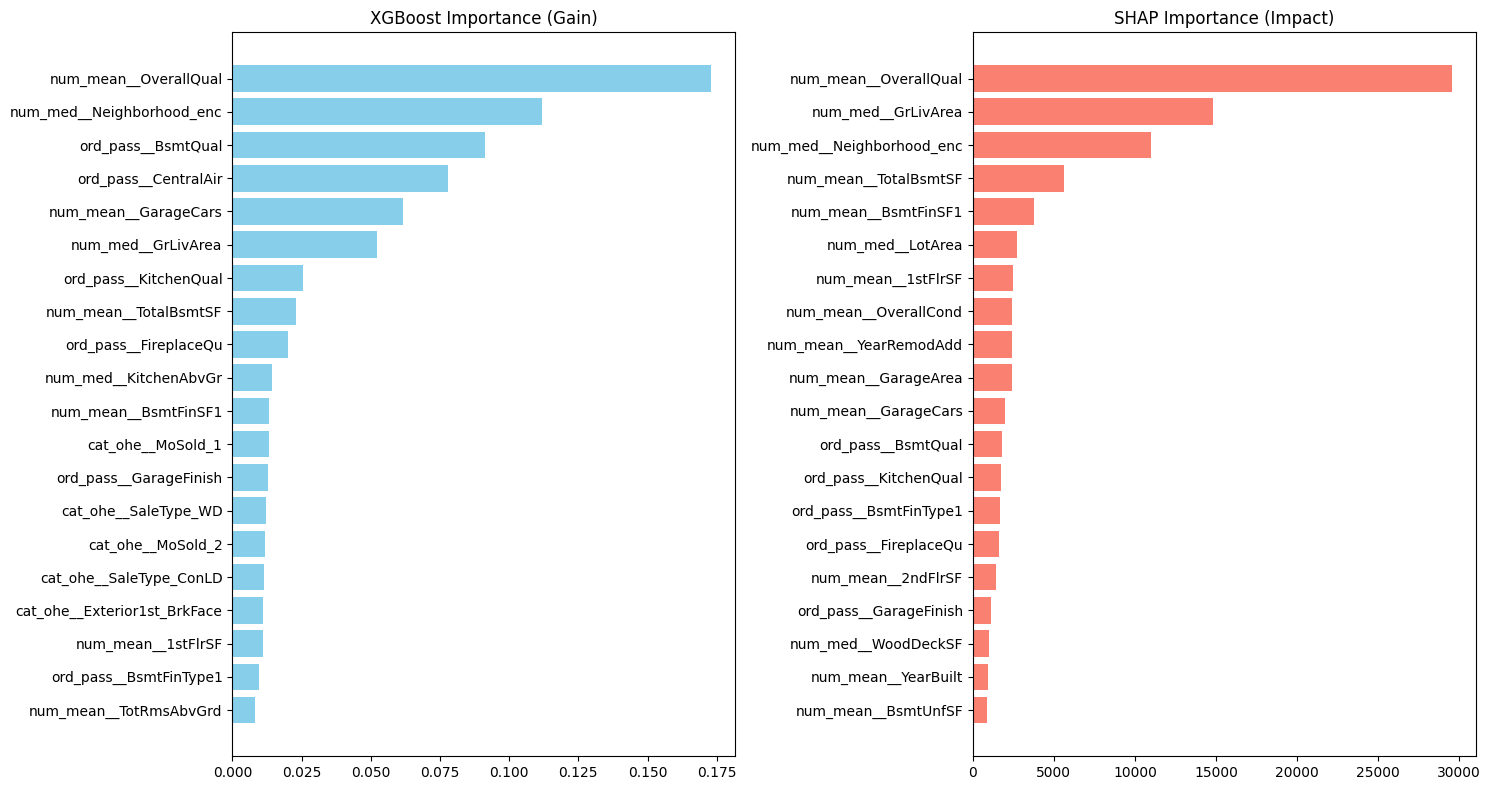

In [505]:
# 1. Get XGBoost Importance (Gain)
xgb_model = my_pipeline.named_steps['model']
feature_names = my_pipeline.named_steps['preprocessor'].get_feature_names_out()
xgb_importances = xgb_model.feature_importances_
sorted_idx_xgb = xgb_importances.argsort()[-20:]

# 2. Get SHAP Importance (Mean Absolute SHAP Value)
# We take the mean of the absolute values to see overall magnitude
shap_importance = np.abs(shap_values).mean(0)
sorted_idx_shap = shap_importance.argsort()[-20:]

# 3. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# XGBoost Plot
ax1.barh(feature_names[sorted_idx_xgb], xgb_importances[sorted_idx_xgb], color='skyblue')
ax1.set_title("XGBoost Importance (Gain)")

# SHAP Plot 
ax2.barh(feature_names[sorted_idx_shap], shap_importance[sorted_idx_shap], color='salmon')
ax2.set_title("SHAP Importance (Impact)")

plt.tight_layout()
plt.show()

### 14.1 Interpreting Feature Importance: XGBoost vs SHAP

The XGBoost feature importance and SHAP importance visualizations highlight different but complementary aspects of the model. **XGBoost feature importance reflects how frequently and effectively features were used to split decision trees during training**, providing insight into the model’s internal learning structure. In contrast, **SHAP importance measures the magnitude of each feature’s contribution to the final predictions**, capturing both positive and negative influences on predicted house prices.

Differences between the two rankings are therefore expected. Features that appear prominently in both plots (e.g., **OverallQual**, **GrLivArea**, **Neighborhood_enc**, and basement-related variables) **represent robust drivers of house prices**, consistently important both in model construction and in prediction influence. Features that appear mainly in SHAP but not in XGBoost still exert meaningful impact on predictions, even if they are not heavily used for tree splits, while features emphasized by XGBoost may be structurally important during training but have smaller net effects on final outputs.

While there is strong overlap among the top features, **SHAP provides a more faithful representation of real-world impact**, particularly for correlated variables.

# 15 Residual Analysis & Visualisation

While Feature Importance identifies the primary drivers of property value, it does not account for the variance in prediction errors. To understand where the model’s logic fails to align with the data, a Residual Analysis was conducted to pinpoint specific instances of under- and over-estimation

* Residuals (**actual price - predicted price**) are roughly centered around zero and fairly symmetric, indicating minimal bias  
* Residuals show no clear pattern across predicted prices, suggesting stable variance
* Interactive hover allows inspection of individual points with unusually large errors

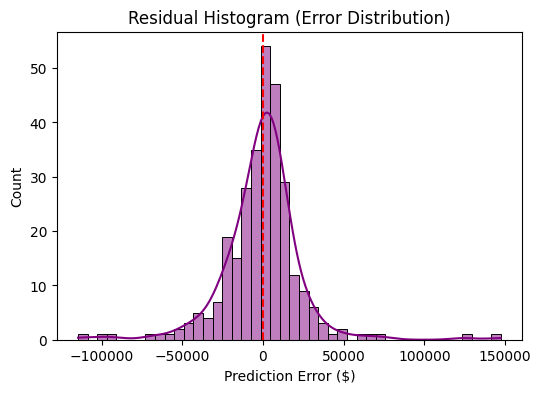

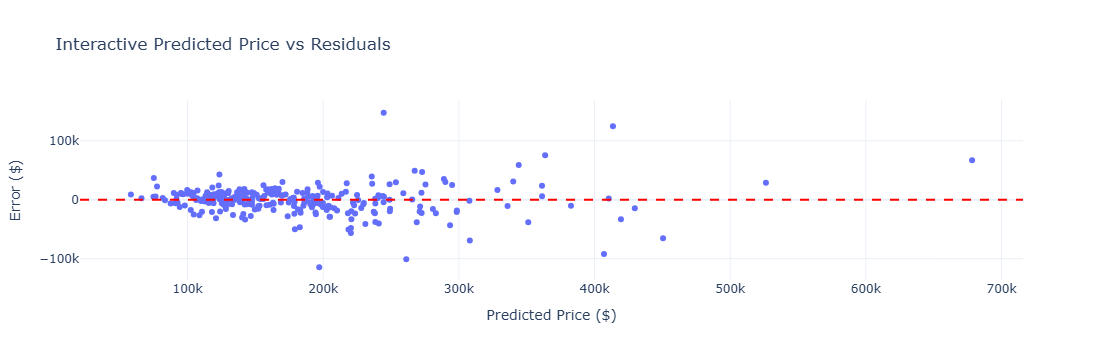

In [509]:
# Calculate residuals
residuals = y_valid - predictions

# 1. Static Residual Histogram 
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.title('Residual Histogram (Error Distribution)')
plt.xlabel('Prediction Error ($)')
plt.ylabel('Count')
plt.show()

# 2. Interactive Predicted vs Residuals Scatter
plot_df = pd.DataFrame({
    'ID': y_valid.index,
    'Predicted_Price': predictions,
    'Residual': residuals,
    'Actual_Price': y_valid
})

fig = px.scatter(
    plot_df,
    x='Predicted_Price',
    y='Residual',
    hover_data=['ID', 'Actual_Price'],
    title='Interactive Predicted Price vs Residuals',
    labels={'Predicted_Price': 'Predicted Price ($)', 'Residual': 'Error ($)'},
    template='plotly_white'
)
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.show()


# 16. Residual Diagnostics

A bidirectional residual analysis was performed to identify properties where the model's prediction errors were highest (positive and negative). Four key outliers were identified (**Ids: 633, 1299, 689, 770**).  
These likely represent market anomalies, such as distressed sales or ultra-luxury custom builds, which deviate from typical residential pricing trends.


Overall, the residual patterns and identified outliers are consistent with the holdout MAE `$15,445` and cross-validated MAE `$15,613 ± 1,307`, confirming that the model is generally stable and performs reliably across typical properties


In [512]:
# Error Investigation DataFrame
# Analyze relative (percentage) prediction errors with respect to actual sale prices


error_df = pd.DataFrame({
    'Actual': y_valid,
    'Predicted': predictions,
    'Error': y_valid - predictions,
    'Percent_Error': abs((y_valid - predictions) / y_valid) * 100
})

# Sort by the biggest errors (Absolute value), display the top 20
nightmare_houses = error_df.sort_values(by='Percent_Error', ascending=False).head(20)
print(nightmare_houses)

      Actual      Predicted          Error  Percent_Error
Id                                                       
633    82500  197080.359375 -114580.359375     138.885284
1299  160000  261217.453125 -101217.453125      63.260908
667   129000  179131.296875  -50131.296875      38.861470
689   392000  244607.031250  147392.968750      37.600247
480    89471  120977.382812  -31506.382812      35.214073
1212  164000  220422.546875  -56422.546875      34.403992
1388  136000  182786.921875  -46786.921875      34.402148
1123  112000   75166.429688   36833.570312      32.887116
309    82500  108760.765625  -26260.765625      31.831231
590    79500  104561.531250  -25061.531250      31.523939
1164  108959  142446.609375  -33487.609375      30.734138
992   168000  218637.000000  -50637.000000      30.141071
1360  315000  407002.968750  -92002.968750      29.207292
964   239000  308095.656250  -69095.656250      28.910316
57    172500  220467.703125  -47967.703125      27.807364
663   110000  

In [514]:
# Get the extreme ends of the Error spectrum
# Provides a dollar-scale view of worst-case model deviations


top_negatives = error_df.nsmallest(2, 'Error') # Over-predicted (Negative Error)
top_positives = error_df.nlargest(2, 'Error')  # Under-predicted (Positive Error)

error_extremes = pd.concat([top_negatives, top_positives])
print('Extreme Error Table:\n\n', error_extremes)

Extreme Error Table:

       Actual      Predicted          Error  Percent_Error
Id                                                       
633    82500  197080.359375 -114580.359375     138.885284
1299  160000  261217.453125 -101217.453125      63.260908
689   392000  244607.031250  147392.968750      37.600247
770   538000  413589.843750  124410.156250      23.124564


# 17. First Attempt to Improve the Model: Outlier Removal

Diagnostics revealed a small cluster of extreme residuals. The goal was to investigate whether the model's predictive accuracy could be improved by addressing four extreme outliers (**Indices: 633, 1299, 689, 770**). Excluding  them temporarily reduced MAE from $15,445 to $13,967, and MAPE from 8.75% to 7.96%, showing that these outliers disproportionately affect percentage error. Direct membership checks run against the indices of both the training and validation splits revealed that **all four outliers are exclusively in the validation set**. Because these records are not in the training set, the model's internal logic was not "poisoned" by them, their removal would not improve the learned parameters or generalization capability of the model.

**Full Validation Set (Unfiltered)** | **MAE: `$15,445` | MAPE: 8.75%**  
**Filtered Validation Set (Minus 4 Outliers)** | **MAE `$13,967` | MAPE: 7.96%** 


**Conclusion**:

The improvement in MAPE confirms that the model is robust, and the residual errors are driven by a few anomalous data points rather than systematic model weaknesses.

The **model performs reliably across typical and atypical transactions**, and retaining these “nightmare” houses in the validation set provides an honest assessment of its predictive performance.

### 17.1 MAE without outliers

In [518]:
# Get the mean absolute errors after excluding outlier houses
# Create a version of y_valid and predictionss without the outliers

clean_indices = y_valid.index.difference([633, 1299, 689, 770])

filtered_y_valid = y_valid.loc[clean_indices]
filtered_preds = pd.Series(predictions, index=y_valid.index).loc[clean_indices]

# Calculate MAE without the "Nightmares"
original_mae = mean_absolute_error(y_valid, predictions)
filtered_mae = mean_absolute_error(filtered_y_valid, filtered_preds)

print(f"Original MAE: ${original_mae:,.2f}")
print(f"MAE without outliers 633, 1299, 689 & 770: ${filtered_mae:,.2f}")

Original MAE: $15,445.43
MAE without outliers 633, 1299, 689 & 770: $13,966.89


### 17.2 MAPE without outliers

In [521]:
# Calculate Filtered Mean Absolute Percentage Error 


original_mape = (abs((y_valid - predictions) / y_valid)).mean() * 100
filtered_mape = (abs((filtered_y_valid - filtered_preds) / filtered_y_valid)).mean() * 100

print(f"Original MAPE: {original_mape:.2f}%")
print(f"MAPE without outliers 633, 1299, 689 & 770: {filtered_mape:.2f}%")

Original MAPE: 8.75%
MAPE without outliers 633, 1299, 689 & 770: 7.96%


In [523]:
# Check if the outlier houses are in the training set

print(633 in X_train.index)
print(1299 in X_train.index)
print(689 in X_train.index)
print(770 in X_train.index)

print(633 in X_valid.index)
print(1299 in X_valid.index)
print(689 in X_valid.index)
print(770 in X_valid.index)

False
False
False
False
True
True
True
True


# 18. Second Attempt at Model Improvement: 
### Feature Engineering (Separate Experiment)

A second model improvement attempt explored additional feature engineering that required constructing new features prior to data splitting. 
Transformations included creating a **Total Area** metric by combining basement and living areas, and deriving **House Age** from the year built and year sold. These engineered features were intended to capture higher-level patterns in the dataset and help the model to learn better. While the baseline model ultimately achieved the lowest Holdout MAE, metrics from Attempt 2 indicate that these transformations improved **cross-validation stability** and revealed **insights into feature interactions**, providing a basis for deeper model exploration and refinement.

To preserve clarity, this experiment was conducted in a separate notebook. **The full analysis and results are available [here](https://github.com/NimotaPro/House-Price-Prediction-Feature-Engineering/blob/main/README.md)**.


While Attempt 2 (Engineered) shows slightly improved cross-validation stability, Attempt 1 (Baseline / current version) is selected as the preferred model due to its **lower Holdout MAE**, indicating stronger predictive power on unseen data.  
The minor improvements in CV metrics from Attempt 2 did not outweigh the increased error on the holdout set, making the baseline model the better trade-off between generalization and performance.  

The divergence between stable CV metrics and a higher Holdout MAE suggests that the additional features in Attempt 2 may have introduced overfitting or feature noise that failed to generalize. This highlights the importance of a true holdout set for final model validation.



| Metric                     | Project 1 (Baseline) | Project 2 (Engineered) | Difference       |
|-----------------------------|--------------------|------------------------|----------------|
| Holdout MAE                 | **15,445**             | 16,570                 | +1,125 (Worse) |
| CV Mean MAE                 | 15,613             | 15,668                 | +55 (Stable)   |
| CV Stability (Std)          | 1,306              | 1,252                  | -54 (Improved) |



# 19. Implementation of Decision Support Logic

**Goal**: To transform raw model predictions into a "Sanity-Check" system that flags pricing anomalies for manual review

The model achieves a MAPE of 8.75%. To ensure the sanity-check system only flags significant anomalies and avoids "false alarms" caused by standard model variance, I have set the audit threshold at ±15%. This ensures that flagged properties are those where the price is deviating significantly beyond the model's expected error margin.

### 19.1 MAPE-Calibrated Pricing Anomaly Detection Logic

The **model_estimate** is used as the denominator to measure deviation relative to the predicted “fair” market value, ensuring the audit flags **reflect anomalies against the model baseline** rather than the potentially noisy actual price.


In [528]:
def valuation_sanity_check(model_estimate, actual_price):
    
    # Business Logic: Flags properties where the price deviation exceeds 1.7x the model's MAPE (8.75%)    
    # Calculate variance against the market baseline (model)
    
    diff_pct = (actual_price - model_estimate) / model_estimate

    # Threshold set at 15% (Statistically significant relative to 8.75% MAPE)
    if diff_pct < -0.15:
        return "🔍 UNDERPRICED: AUDIT REQUIRED"
    elif diff_pct > 0.15:
        return "🚩 OVERPRICED: AUDIT REQUIRED"
    else:
        return "🟢 VALIDATED"

# Testing with sample metrics. If model says 100K:
# and house is listed at 116k (16% diff), it should flag
print(valuation_sanity_check(100000, 116000))

# listed at 80k (20% diff), it should flag
print(valuation_sanity_check(100000, 80000))

# listed at 95k (5% diff), it should validate
print(valuation_sanity_check(100000, 95000))


🚩 OVERPRICED: AUDIT REQUIRED
🔍 UNDERPRICED: AUDIT REQUIRED
🟢 VALIDATED


### 19.2 Creation of Decision DataFrame with Audit Flags

In [531]:
# 1. Construct decision-level DataFrame combining actual and predicted values
decision_df = pd.DataFrame({
    'Actual_Price': y_valid,
    'Predicted_Price': predictions
})

# 2. Apply valuation sanity-check logic to generate audit status per observation
# The function is applied row-wise to evaluate pricing deviations
decision_df['Sanity_Check_Status'] = decision_df.apply(
    lambda row: valuation_sanity_check(
        row['Predicted_Price'], 
        row['Actual_Price']
    ),
    axis=1
)

# 3. Inspect sample audit outcomes
decision_df.head(10)


,Actual_Price,Predicted_Price,Sanity_Check_Status
Id,,,
530,200624,240993.156250,🔍 UNDERPRICED: AUDIT REQUIRED
492,133000,149594.875000,🟢 VALIDATED
460,110000,100068.828125,🟢 VALIDATED
280,192000,210217.828125,🟢 VALIDATED
656,88000,98003.406250,🟢 VALIDATED
1014,85000,102411.843750,🔍 UNDERPRICED: AUDIT REQUIRED
1404,282922,253584.968750,🟢 VALIDATED
602,141000,129930.789062,🟢 VALIDATED
1183,745000,678321.125000,🟢 VALIDATED


### 19.3 Decision Support Summary: Validated vs. Flagged Properties


In [534]:
# 1. Calculate the frequency of each status
audit_counts = decision_df['Sanity_Check_Status'].value_counts()

# 2. Calculate the percentage of the portfolio that needs review
total_properties = len(decision_df)
audit_needed_count = audit_counts.get("🔍 UNDERPRICED: AUDIT REQUIRED") + \
                     audit_counts.get("🚩 OVERPRICED: AUDIT REQUIRED")

audit_percentage = (audit_needed_count / total_properties) * 100
validated_percentage = (1 - audit_needed_count / total_properties) * 100


print(f"--- Decision Support Summary ---")
print(f"Total Properties Evaluated: {total_properties}")
print(f"Properties Validated: {audit_counts.get('🟢 VALIDATED')} ({validated_percentage:.0f}%)")
print(f"Properties Flagged for Audit: {audit_needed_count} ({audit_percentage:.0f}%)")
print("-" * 30)
print(audit_counts)

--- Decision Support Summary ---
Total Properties Evaluated: 292
Properties Validated: 250 (86%)
Properties Flagged for Audit: 42 (14%)
------------------------------
Sanity_Check_Status
🟢 VALIDATED                      250
🔍 UNDERPRICED: AUDIT REQUIRED     26
🚩 OVERPRICED: AUDIT REQUIRED      16
Name: count, dtype: int64


### 19.4 Visualization of Property Audit Status Distribution

**Interpretation**:

The bar chart shows that the majority of properties are validated (🟢 VALIDATED), while a smaller proportion are flagged as underpriced (🔍) or overpriced (🚩). This confirms that the ±15% audit threshold captures only significant pricing deviations, minimizing false alarms while highlighting properties that need manual review.

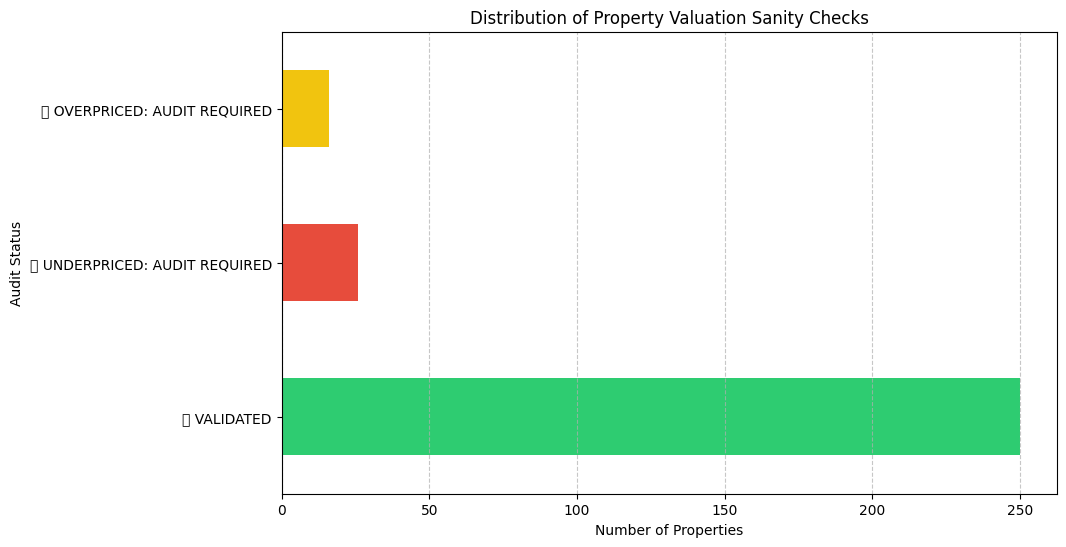

In [537]:
# Create a bar chart 
plt.figure(figsize=(10, 6))
audit_counts.plot(kind='barh', color=['#2ecc71', '#e74c3c', '#f1c40f'])
plt.title('Distribution of Property Valuation Sanity Checks')
plt.xlabel('Number of Properties')
plt.ylabel('Audit Status')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 20. Business Impact & Future Roadmap

**Current Value:**
The system now automates the property triage process. Rather than analysts manually reviewing all listings, they only need to focus on the **14% of properties flagged** as **AUDIT: Underpriced** or **AUDIT: Overpriced**. This significantly reduces manual workload while ensuring that substantial pricing anomalies are caught.

**Future Iterations:**

1. **Dynamic Audit Thresholds:**
   Adjust the ±15% deviation threshold based on property type and market segment:

   * **Luxury homes** may require a **lower tolerance**, since small pricing deviations have a higher financial impact.
   * **Fixer-uppers** can allow a **higher tolerance**, as renovation needs naturally introduce more price variability.
     This ensures that the audit system flags only **truly anomalous properties**, minimizing false positives.

2. **Geo-Spatial Contextualization:**
   Incorporate **location-based insights** to differentiate genuine overpricing from neighborhood-specific market trends. This reduces false positives in high-demand areas and provides analysts with richer context.

3. **Decision Layer Refinement:**
   Enhance the sanity-check system by integrating **multi-factor checks** such as neighborhood trends, property type, and historical sales patterns. This ensures that flagged properties are not only statistically anomalous but also **business-relevant**.


# 21. Project Summary

This project develops a **transparent and robust machine learning pipeline** to predict residential property prices while integrating a **decision-support layer** that filters market noise and flags significant pricing anomalies. An **XGBoost regressor** was selected for its strong performance on tabular data and its ability to capture non-linear relationships across structural, temporal, and location-based features.

Interestingly, while high-value homes (e.g., Id 770) generate the largest absolute errors in dollars, **MAPE is most sensitive to low-value properties** (e.g., Id 633, error of 138%), highlighting the inherent bias of percentage-based metrics toward smaller transactions.



### Data Preparation and Preprocessing

All preprocessing steps were fitted exclusively on the training data to avoid leakage.

* **Numeric features:** Analyzed for skewness; lightly skewed features imputed with mean, heavily skewed features with median.
* **Categorical features:**

  * Moderate-to-low cardinality: one-hot encoded
  * Ordinal features: manually encoded using domain knowledge
  * High-cardinality **Neighborhood**: target encoded using local neighborhood means

These steps preserved feature integrity and captured meaningful location-specific signals.


### Modeling and Evaluation

Model performance was evaluated with **k-fold cross-validation** and a held-out validation set.

* **Primary metric:** Holdout MAE -> $15,445
* **Complementary metric:** MAPE -> 8.75%

Residual analysis identified extreme outliers (Ids 633, 1299, 689, 770) that disproportionately influenced metrics. Post-hoc exclusion of these cases reduced MAE to $13,967 and MAPE to 7.96%, but the final evaluation retained all observations to reflect real-world deployment conditions.



### Feature Integrity & Additional Experiments

The model relies on fundamental valuation drivers such as **Overall Quality**, **Living Area**, and **Neighborhood_enc**, aligning with real-world logic. Secondary experiments explored engineered features (e.g., **TotalSF**, **HouseAge**) which improved cross-validation stability but increased holdout MAE. The **baseline model** was retained for superior predictive performance on unseen data.



### Decision-Support Layer

A **Property Valuation Sanity-Check System** was implemented to automatically categorize listings as **PROPERTY_VALIDATED** or requiring **manual audit**:

* Based on the model’s **MAPE of 8.75%**, a **±15% variance threshold** was established.
* **Outcome:**

  * **Validated 86%** of properties as within expected market ranges
  * **Isolated 14%** of listings as high-priority audit candidates (Overpriced/Underpriced)
* **Business impact:** Human auditors focus solely on flagged anomalies, **reducing manual review load** and improving operational efficiency.



### Key Insights

* The model learned meaningful valuation drivers, including structural attributes and neighborhood effects, consistent with market logic.
* MAPE is highly sensitive to low-priced properties, demonstrating the importance of complementary metrics.
* The decision-support layer translates model predictions into actionable business outcomes, ensuring flagged anomalies are statistically significant and business-relevant.


### Conclusion

The project delivers a **reliable, transparent, and actionable valuation pipeline**, combining predictive accuracy with a decision-support system that:

* Automates anomaly detection
* Prioritizes analyst attention
* Maintains interpretability for extreme cases

This provides a strong foundation for **future refinements**, including dynamic thresholds, geo-spatial contextualization, and multi-factor audit logic.
